In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
nr = sc.read_h5ad('./NR/V2L_NR_L23_filter.h5ad')
dr = sc.read_h5ad('./DR/V2L_DR_L23_filter.h5ad')

In [3]:
nr_ptime = pd.read_csv('./ptime/HVG_N_V2L_L23_pseudotime.txt',sep='\t')
dr_ptime = pd.read_csv('./ptime/HVG_D_V2L_L23_pseudotime.txt',sep='\t')

In [4]:
import seaborn as sns
sns.set_theme(style="ticks")

In [5]:
pc_gene = pd.read_csv('V2L_L23_Lasso_PC1rank.xls',sep='\t')

In [6]:
import anndata 
from scipy.stats import zscore
from scipy import sparse 
import itertools
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [7]:
hvg_nr = nr[:, nr.var.highly_variable]
hvg_dr = dr[:, dr.var.highly_variable]

         Gene  Lasso Coefficient  Lasso Coefficient abs
1595    Cdh13           0.298255               0.298255
1619    Cntn5           0.294814               0.294814
2774    Robo1           0.247120               0.247120
1645  Kirrel3           0.232682               0.232682
3144   Sorcs3          -0.199840               0.199840
['Cdh13' 'Cntn5' 'Robo1' 'Kirrel3' 'Sorcs3' 'Pde7b' 'Ptprk' 'Slc24a2'
 'Gpc6' 'Egfem1' 'Pex5l' 'Pcdh15' 'Frmd5' '6530403H02Rik' 'Dscaml1' 'Gpc5'
 '4930419G24Rik' 'Gm15398' 'Tafa1' 'Unc5d' 'Hs6st3' 'Cntnap5a' 'Maml3'
 'Brinp3' 'Dpyd' 'Mast4' 'Mgat4c' 'Cntnap2' 'Sema6d' 'Sgcd' 'Meis2'
 'Sorcs1' 'Alcam' 'Shisa9' 'Prr16' 'Slc1a2' 'Glis3' 'Gm37459' 'Nell1'
 'Limch1' 'Grip1' 'Mast3' 'Gm11149' 'Elmo1' 'Nckap5' 'Kcnc2' 'Grid2'
 'Trpm3' 'Kcnh5' 'Tmeff2' 'Gm32647' 'Mir99ahg' 'Spon1' 'Pde4b' 'Plxdc2'
 'Mapk4' 'Slc35f1' 'Klhl2' 'Agap1' 'Gm20713' 'Rcan2' 'Ptprt' 'Man1a'
 'Col23a1' 'Cadps2' 'Fgf13' 'Gm3764' 'Gm32509' 'Thsd7a' 'Pcdh11x' 'Sox5'
 'Gm15261' 'Arhgef28' 'Npas

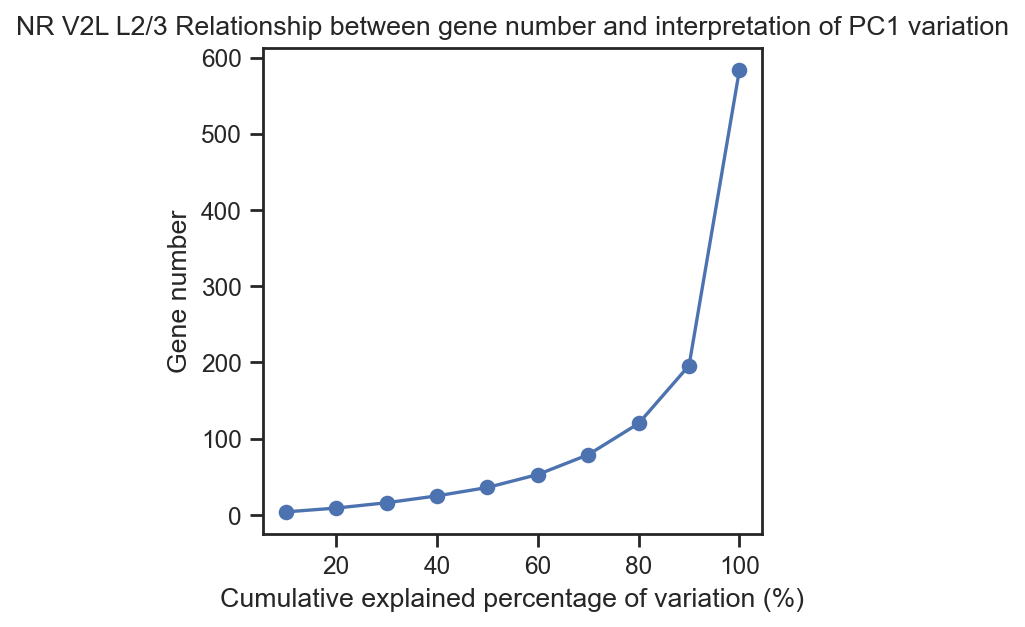

In [8]:
from sklearn.linear_model import LassoCV
sns.set_theme(style="ticks")

np.random.seed(0)
pca_nr = PCA(n_components=50)
hvg_nr_exp = np.array(hvg_nr.X.todense())
pcs_nr = pca_nr.fit_transform(hvg_nr_exp)
genes_sel_nr = hvg_nr.var.index.values
pc1_nr = pca_nr.components_[0]
pc1_idx_nr = np.argsort(np.abs(pc1_nr))[::-1]
genes_sel_nr[pc1_idx_nr]
nr_pca_gene = pd.DataFrame()
nr_pca_gene['PC1'] = genes_sel_nr[pc1_idx_nr]
nr_pca_gene['rank'] = range(nr_pca_gene.shape[0])

scaler = StandardScaler()
hvg_nr_exp_df= pd.DataFrame(hvg_nr_exp,index=hvg_nr.obs.index,columns= hvg_nr.var.index)
X_scaled_nr = scaler.fit_transform(hvg_nr_exp)

# 以第一个主成分为目标变量
y_pca1_nr = pcs_nr[:, 0]  # 使用第一个主成分


# Lasso 模型（L1正则化）
lasso = Lasso(alpha=0.001900964050575277)  # alpha 控制正则化强度，适当调整
lasso.fit(X_scaled_nr, y_pca1_nr)

# Step 4: 查看每个基因的系数（即其对 PCA 变异的贡献）
lasso_coefficients_nr = lasso.coef_
#取lasso系数的绝对值
lasso_coefficients_abs_nr = np.abs(lasso_coefficients_nr)
# 将基因名称和相应的 Lasso 系数保存到 DataFrame 中
gene_contributions_nr = pd.DataFrame({
    'Gene': hvg_nr_exp_df.columns,
    'Lasso Coefficient': lasso_coefficients_nr,
    'Lasso Coefficient abs': lasso_coefficients_abs_nr
})
# 查看对第一个主成分有较大贡献的基因
gene_contributions_abs_nr = gene_contributions_nr.sort_values(by='Lasso Coefficient abs', ascending=False)
print(gene_contributions_abs_nr.head())

# 假设 gene_names 是与基因表达矩阵列对应的基因名称列表
gene_names_nr = np.array(gene_contributions_nr['Gene']) 

# 按贡献率排序
sorted_contribution_nr = np.sort(lasso_coefficients_abs_nr)[::-1]

# 计算累计贡献率
cumulative_contribution_nr = np.cumsum(sorted_contribution_nr)

# 计算总贡献
total_contribution_nr = cumulative_contribution_nr[-1]

# 按贡献率排序，获取贡献最大的基因索引
sorted_idx_nr = np.argsort(np.abs(lasso_coefficients_nr))[::-1]

# 获取解释90%变异的基因索引
num_genes_90pct = np.argmax(cumulative_contribution_nr >= 0.9 * total_contribution_nr) + 1
genes_90pct_idx_nr = sorted_idx_nr[:num_genes_90pct]

# 打印这些基因的名称
genes_90pct_nr = gene_names_nr[genes_90pct_idx_nr]
print(genes_90pct_nr)
percentages = np.arange(0.1, 1.1, 0.1)

# 记录每个百分比所需的基因数
gene_counts_nr = [np.argmax(cumulative_contribution_nr >= p * total_contribution_nr) + 1 for p in percentages]

print("解释不同变异百分比所需的基因数:", gene_counts_nr)
import matplotlib.pyplot as plt

# 绘制基因数量与解释方差之间的折线图
plt.plot(percentages * 100, gene_counts_nr, marker='o')
plt.xlabel('Cumulative explained percentage of variation (%)')
plt.ylabel('Gene number')
plt.title('NR V2L L2/3 Relationship between gene number and interpretation of PC1 variation')
#plt.grid(True)
plt.show()

In [9]:
num_genes = np.argmax(cumulative_contribution_nr >= 1 * total_contribution_nr) + 1
genes_idx_nr = sorted_idx_nr[:num_genes]
genes_nr = gene_names_nr[genes_idx_nr]


               Gene  Lasso Coefficient  Lasso Coefficient abs
1773          Cdh13           0.413706               0.413706
1803          Cntn5           0.256518               0.256518
280            Etl4          -0.203215               0.203215
3072          Epha6           0.194739               0.194739
678   6530403H02Rik           0.186056               0.186056
['Cdh13' 'Cntn5' 'Robo1' 'Kirrel3' 'Sorcs3' 'Pde7b' 'Ptprk' 'Slc24a2'
 'Gpc6' 'Egfem1' 'Pex5l' 'Pcdh15' 'Frmd5' '6530403H02Rik' 'Dscaml1' 'Gpc5'
 '4930419G24Rik' 'Gm15398' 'Tafa1' 'Unc5d' 'Hs6st3' 'Cntnap5a' 'Maml3'
 'Brinp3' 'Dpyd' 'Mast4' 'Mgat4c' 'Cntnap2' 'Sema6d' 'Sgcd' 'Meis2'
 'Sorcs1' 'Alcam' 'Shisa9' 'Prr16' 'Slc1a2' 'Glis3' 'Gm37459' 'Nell1'
 'Limch1' 'Grip1' 'Mast3' 'Gm11149' 'Elmo1' 'Nckap5' 'Kcnc2' 'Grid2'
 'Trpm3' 'Kcnh5' 'Tmeff2' 'Gm32647' 'Mir99ahg' 'Spon1' 'Pde4b' 'Plxdc2'
 'Mapk4' 'Slc35f1' 'Klhl2' 'Agap1' 'Gm20713' 'Rcan2' 'Ptprt' 'Man1a'
 'Col23a1' 'Cadps2' 'Fgf13' 'Gm3764' 'Gm32509' 'Thsd7a' 'Pcdh11x

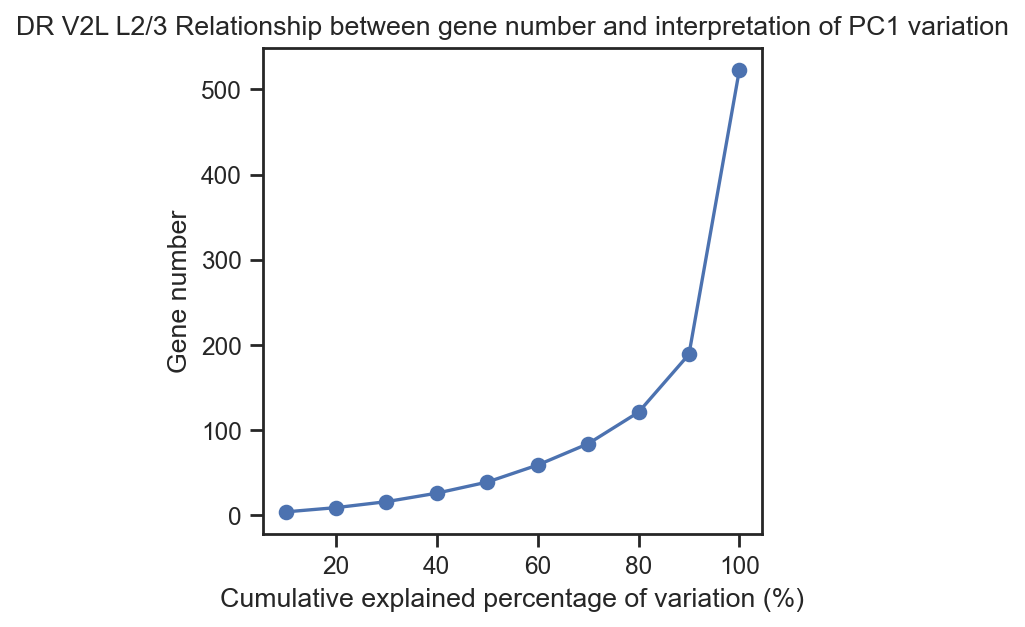

In [10]:
np.random.seed(0)
pca_dr = PCA(n_components=50)
hvg_dr_exp = np.array(hvg_dr.X.todense())
pcs_dr = pca_dr.fit_transform(hvg_dr_exp)
genes_sel_dr = hvg_dr.var.index.values
pc1_dr = pca_dr.components_[0]
pc1_idx_dr = np.argsort(np.abs(pc1_dr))[::-1]
genes_sel_dr[pc1_idx_dr]

dr_pca_gene = pd.DataFrame()
dr_pca_gene['PC1'] = genes_sel_dr[pc1_idx_dr]

dr_pca_gene['rank'] = range(dr_pca_gene.shape[0])

scaler = StandardScaler()
hvg_dr_exp_df= pd.DataFrame(hvg_dr_exp,index=hvg_dr.obs.index,columns= hvg_dr.var.index)
X_scaled_dr = scaler.fit_transform(hvg_dr_exp)

# 以第一个主成分为目标变量
y_pca1_dr = pcs_dr[:, 0]  # 使用第一个主成分

# Lasso 模型（L1正则化）
lasso = Lasso(alpha=0.0024606294277876805)  # alpha 控制正则化强度，适当调整
lasso.fit(X_scaled_dr, y_pca1_dr)

# Step 4: 查看每个基因的系数（即其对 PCA 变异的贡献）
lasso_coefficients_dr = lasso.coef_
#取lasso系数的绝对值
lasso_coefficients_abs_dr = np.abs(lasso_coefficients_dr)
# 将基因名称和相应的 Lasso 系数保存到 DataFrame 中
gene_contributions_dr = pd.DataFrame({
    'Gene': hvg_dr_exp_df.columns,
    'Lasso Coefficient': lasso_coefficients_dr,
    'Lasso Coefficient abs': lasso_coefficients_abs_dr
})
# 查看对第一个主成分有较大贡献的基因
gene_contributions_abs_dr = gene_contributions_dr.sort_values(by='Lasso Coefficient abs', ascending=False)
print(gene_contributions_abs_dr.head())

# 假设 gene_names 是与基因表达矩阵列对应的基因名称列表
gene_names_dr = np.array(gene_contributions_dr['Gene']) 

# 按贡献率排序
sorted_contribution_dr = np.sort(lasso_coefficients_abs_dr)[::-1]

# 计算累计贡献率
cumulative_contribution_dr = np.cumsum(sorted_contribution_dr)

# 计算总贡献
total_contribution_dr = cumulative_contribution_dr[-1]

# 按贡献率排序，获取贡献最大的基因索引
sorted_idx_dr = np.argsort(np.abs(lasso_coefficients_dr))[::-1]

# 获取解释90%变异的基因索引
num_genes_90pct_dr = np.argmax(cumulative_contribution_dr >= 0.9 * total_contribution_dr) + 1
genes_90pct_idx_dr = sorted_idx_nr[:num_genes_90pct_dr]

# 打印这些基因的名称
genes_90pct_dr = gene_names_nr[genes_90pct_idx_dr]
print(genes_90pct_dr)

# 记录每个百分比所需的基因数
gene_counts_dr = [np.argmax(cumulative_contribution_dr >= p * total_contribution_dr) + 1 for p in percentages]

print("解释不同变异百分比所需的基因数:", gene_counts_dr)

# 绘制基因数量与解释方差之间的折线图
plt.plot(percentages * 100, gene_counts_dr, marker='o')
plt.xlabel('Cumulative explained percentage of variation (%)')
plt.ylabel('Gene number')
plt.title('DR V2L L2/3 Relationship between gene number and interpretation of PC1 variation')
#plt.grid(True)
plt.show()

In [11]:
num_genes = np.argmax(cumulative_contribution_dr >= 1 * total_contribution_dr) + 1
genes_idx_dr = sorted_idx_dr[:num_genes]
genes_dr = gene_names_dr[genes_idx_dr]

dr_pca_gene = pd.DataFrame()
dr_pca_gene['PC1'] = genes_sel_dr[pc1_idx_dr]
dr_pca_gene['rank'] = range(dr_pca_gene.shape[0])

df_nr = pd.DataFrame()
df_dr = pd.DataFrame()
index = list(nr_pca_gene['PC1'])
nr_PC1 = list(nr_pca_gene['rank'])
df_nr.index = index
df_nr['nr_PC1'] = nr_PC1
dic_nr = df_nr['nr_PC1'].to_dict()

index = list(dr_pca_gene['PC1'])
dr_PC1 = list(dr_pca_gene['rank'])
df_dr.index = index
df_dr['dr_PC1'] = dr_PC1
dic_dr = df_dr['dr_PC1'].to_dict()

pc_lasso_union_list = list(set(list(genes_nr)) | set(list(genes_dr)))

print("解释NR_DR_PC1的总基因数:", len(pc_lasso_union_list))
print("解释NR_PC1的基因数:", len(list(genes_nr)))
print("解释DR_PC1的基因数:", len(list(genes_dr)))

pc_lasso_df = pd.DataFrame()
pc_lasso_df['Gene'] = pc_lasso_union_list
           
nr_pc_lasso = []
for i in range(pc_lasso_df.shape[0]):
    if pc_lasso_df['Gene'][i] in dic_nr.keys():
        nr_pc_lasso.append(dic_nr[pc_lasso_df['Gene'][i]])
    else:
        nr_pc_lasso.append('4000')
pc_lasso_df['nr_pc_lasso']=nr_pc_lasso
dr_pc_lasso = []
for i in range(pc_lasso_df.shape[0]):
    if pc_lasso_df['Gene'][i] in dic_dr.keys():
        dr_pc_lasso.append(dic_dr[pc_lasso_df['Gene'][i]])
    else:
        dr_pc_lasso.append('4000')
pc_lasso_df['dr_pc_lasso']=dr_pc_lasso

foldchange= []
for i in range(pc_lasso_df.shape[0]):
    foldchange.append((int(pc_lasso_df['dr_pc_lasso'][i])+1)/(int(pc_lasso_df['nr_pc_lasso'][i])+1))
pc_lasso_df['foldchange'] = foldchange
pc_lasso_df['logFC'] = np.log(pc_lasso_df['foldchange'])

解释NR_DR_PC1的总基因数: 745
解释NR_PC1的基因数: 584
解释DR_PC1的基因数: 523


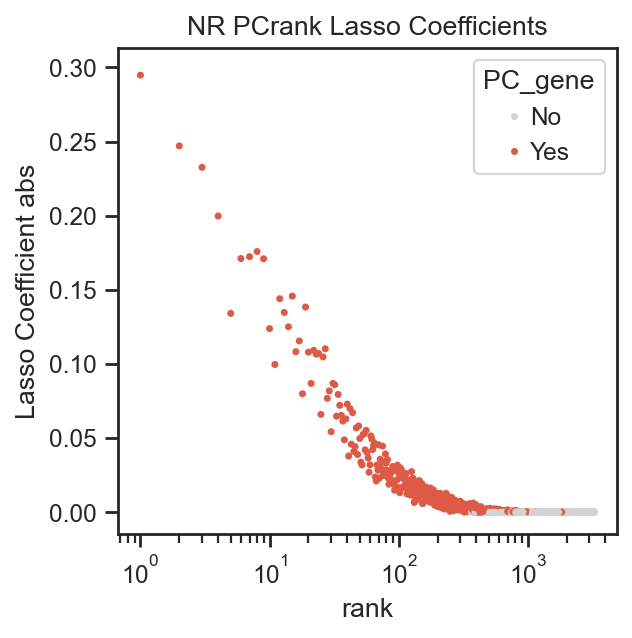

In [12]:
nr_pca_gene = pd.DataFrame()
nr_pca_gene['Gene'] = genes_sel_nr[pc1_idx_nr]
nr_pca_gene['rank'] = range(nr_pca_gene.shape[0])
nr_merge = pd.merge(nr_pca_gene, gene_contributions_abs_nr, on='Gene', how='outer')
PC_gene = []
for i in range(nr_merge.shape[0]):
    if nr_merge['Gene'][i] in set(genes_nr):
        PC_gene.append('Yes')
    else:
        PC_gene.append('No')
nr_merge['PC_gene'] = PC_gene
nr_PC_gene = nr_merge[nr_merge['PC_gene'] == 'Yes']

custom_palette = {'Yes': '#DD5A46', 'No': 'lightgray'}
fig, ax = plt.subplots(figsize=(4, 4))

# 使用scatterplot方法，指定自定义颜色调色板
sns.scatterplot(data=nr_merge, x='rank', y='Lasso Coefficient abs', s=10, hue='PC_gene',
                palette=custom_palette, edgecolor='none', ax=ax)

# 设置对数坐标轴
ax.set_xscale('log')

# 设置图标题
plt.title('NR PCrank Lasso Coefficients')

# 显示图形
plt.savefig('V2L_L23_NR_PCrank_Lasso_Coefficients.pdf')

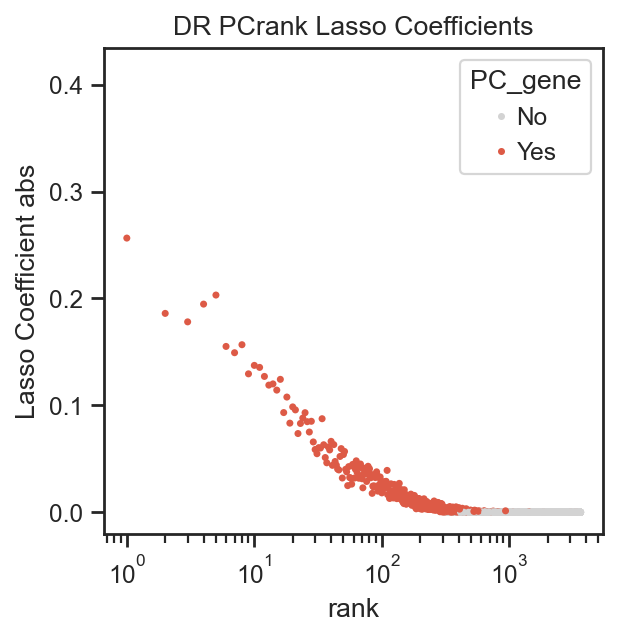

In [13]:
dr_pca_gene = pd.DataFrame()
dr_pca_gene['Gene'] = genes_sel_dr[pc1_idx_dr]
dr_pca_gene['rank'] = range(dr_pca_gene.shape[0])
dr_merge = pd.merge(dr_pca_gene, gene_contributions_abs_dr, on='Gene', how='outer')

PC_gene = []
for i in range(dr_merge.shape[0]):
    if dr_merge['Gene'][i] in set(genes_dr):
        PC_gene.append('Yes')
    else:
        PC_gene.append('No')
dr_merge['PC_gene'] = PC_gene
dr_PC_gene = dr_merge[dr_merge['PC_gene'] == 'Yes']

custom_palette = {'Yes': '#DD5A46', 'No': 'lightgray'}
fig, ax = plt.subplots(figsize=(4, 4))

# 使用scatterplot方法，指定自定义颜色调色板
sns.scatterplot(data=dr_merge, x='rank', y='Lasso Coefficient abs', s=10, hue='PC_gene',
                palette=custom_palette, edgecolor='none', ax=ax)

# 设置对数坐标轴
ax.set_xscale('log')

# 设置图标题
plt.title('DR PCrank Lasso Coefficients')

# 显示图形
plt.savefig('V2L_L23_DR_PCrank_Lasso_Coefficients.pdf')

In [14]:
nr_exp=pd.DataFrame(nr.X.todense(),index=nr.obs.index,columns=nr.var.index)
nr_exp = nr_exp.reset_index()
nr_exp['cell_id_match'] = nr_exp['index'].str[:12]
df_ptime_nr = pd.merge(nr_exp, nr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

# 删除不必要的列并重新设置索引
df_ptime_nr = df_ptime_nr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_nr = df_ptime_nr.dropna()
df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)


dr_exp=pd.DataFrame(dr.X.todense(),index=dr.obs.index,columns=dr.var.index)
dr_exp = dr_exp.reset_index()
dr_exp['cell_id_match'] = dr_exp['index'].str[:12]
df_ptime_dr = pd.merge(dr_exp, dr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

# 删除不必要的列并重新设置索引
df_ptime_dr = df_ptime_dr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_dr = df_ptime_dr.dropna()
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)

df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)
df_ptime_nr_sorted['index'] = range(df_ptime_nr_sorted.shape[0])
df_ptime_nr_sorted['index_bin'] = pd.cut(df_ptime_nr_sorted['index'], bins=np.arange(0, 4238 + 4238/100, 4238/100))
bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
df_ptime_dr_sorted['index'] = range(df_ptime_dr_sorted.shape[0])
df_ptime_dr_sorted['index_bin'] = pd.cut(df_ptime_dr_sorted['index'], bins=np.arange(0, 4017 + 4017/100, 4017/100))
bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()
bin_means_nr['index'] = range(bin_means_nr.shape[0])
bin_means_dr['index'] = range(bin_means_dr.shape[0])

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_32612/1280202486.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_32612/1280202486.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()


In [15]:
bin_means_nr_ = bin_means_nr
bin_means_nr_.index = list(bin_means_nr_['index'])
del bin_means_nr_['index']
bin_means_nr_T = bin_means_nr_.T

bin_means_dr_ = bin_means_dr
bin_means_dr_.index = list(bin_means_dr_['index'])
del bin_means_dr_['index']
bin_means_dr_T = bin_means_dr_.T

slope_ =[]
for i in range(bin_means_dr_T.shape[0]):
    x = np.array(bin_means_dr.index)
    y = np.array(bin_means_dr[bin_means_dr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_dr_T['slope'] = slope_

slope_ =[]
for i in range(bin_means_nr_T.shape[0]):
    x = np.array(bin_means_nr.index)
    y = np.array(bin_means_nr[bin_means_nr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_nr_T['slope'] = slope_

In [16]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]

In [17]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_dr_T.index)
slope_df['slope']= list(bin_means_dr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(dr_pc_gene.shape[0]):
    if dr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][dr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
dr_pc_gene['slope'] = slope
dr_pc_gene = dr_pc_gene[dr_pc_gene['slope'] != 'No']
dr_pc_gene['slope_abs'] = dr_pc_gene['slope'].abs()

dr_pc_gene_filter = dr_pc_gene[dr_pc_gene['dr_pc_lasso'] != 4000]
###
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_nr_T.index)
slope_df['slope']= list(bin_means_nr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(nr_pc_gene.shape[0]):
    if nr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][nr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
nr_pc_gene['slope'] = slope
nr_pc_gene = nr_pc_gene[nr_pc_gene['slope'] != 'No']
nr_pc_gene['slope_abs'] = nr_pc_gene['slope'].abs()

nr_pc_gene_filter = nr_pc_gene[nr_pc_gene['nr_pc_lasso'] != 4000]

nr_pc_gene_filter['Cond'] = 'NR'
dr_pc_gene_filter['Cond'] = 'DR'

nr_pc_gene_filter['Rank'] = nr_pc_gene_filter['nr_pc_lasso']
dr_pc_gene_filter['Rank'] = dr_pc_gene_filter['dr_pc_lasso']
del nr_pc_gene_filter['nr_pc_lasso']
del dr_pc_gene_filter['dr_pc_lasso']
df_merge_pc_gene = pd.concat([nr_pc_gene_filter, dr_pc_gene_filter])

df_merge_pc_gene['slope_abs'] = df_merge_pc_gene['slope_abs']*100

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_32612/694031600.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_32612/694031600.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_32612/694031600.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [18]:
df_NR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'NR']
df_DR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'DR']

In [19]:
nr_pc_gene_filter

,Gene,logFC,slope,slope_abs,Cond,Rank
0,Nrbp2,0.406365,0.000683,0.000683,NR,291
1,Unc5c,-1.247012,-0.001395,0.001395,NR,590
2,Kif13b,-0.400450,-0.000177,0.000177,NR,655
3,Nfia,1.287674,0.001236,0.001236,NR,178
4,Fam210a,0.490547,0.000678,0.000678,NR,441
...,...,...,...,...,...,...
740,Tyrobp,-0.811531,-0.000020,0.000020,NR,2507
741,Zfp608,0.282400,0.002650,0.002650,NR,110
742,Lrrn1,-1.102098,0.000315,0.000315,NR,482
743,Oprm1,4.047282,-0.000581,0.000581,NR,241


In [20]:
from scipy.stats import zscore

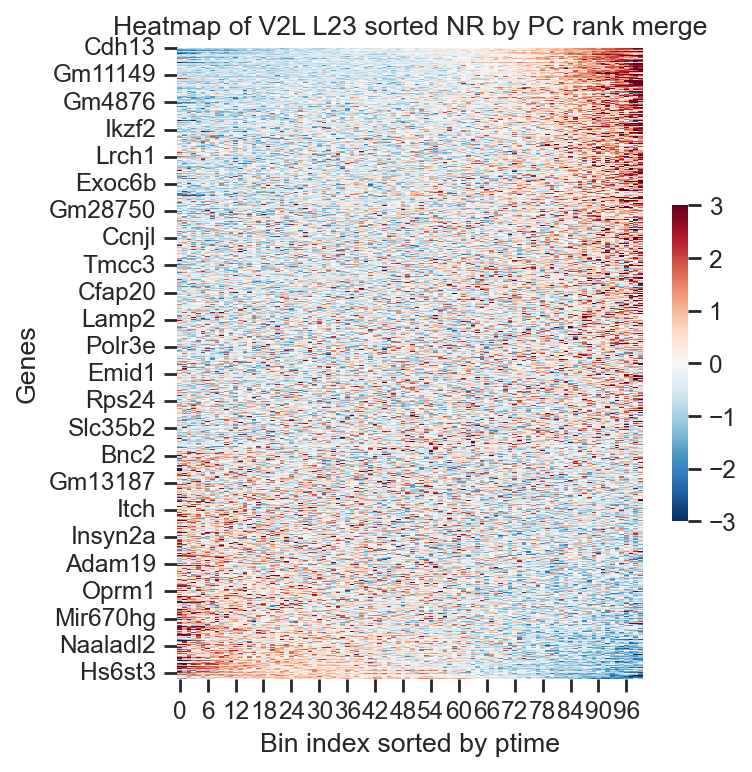

In [21]:
rank_df = pd.DataFrame()
rank_df.index=list(nr_pc_gene_filter['Gene'])
rank_df['PC_rank']= list(nr_pc_gene_filter['Rank'])
rank_dic = rank_df.to_dict()

PC_rank = []
for i in range(bin_means_nr_T.shape[0]):
    if bin_means_nr_T.index[i] in rank_df['PC_rank'].keys():
        PC_rank.append(rank_df['PC_rank'][bin_means_nr_T.index[i]])
    else:
        PC_rank.append('No')
bin_means_nr_T['PC_rank'] = PC_rank

bin_means_nr_T_pc_gene = bin_means_nr_T[bin_means_nr_T['PC_rank'] != 'No']

bin_means_nr_T_pc_gene_sorted = bin_means_nr_T_pc_gene.sort_values(by='PC_rank', ascending=True)

bin_means_nr_T_pc_gene_sorted_positive = bin_means_nr_T_pc_gene_sorted[bin_means_nr_T_pc_gene_sorted['slope'] >= 0]
bin_means_nr_T_pc_gene_sorted_negtive = bin_means_nr_T_pc_gene_sorted[bin_means_nr_T_pc_gene_sorted['slope'] <= 0]
df_nr_reversed = bin_means_nr_T_pc_gene_sorted_negtive.reindex(index=bin_means_nr_T_pc_gene_sorted_negtive.index[::-1])

df_nr_combined = pd.concat([bin_means_nr_T_pc_gene_sorted_positive, df_nr_reversed])
del df_nr_combined['slope']
del df_nr_combined['PC_rank']
# 使用 seaborn 绘制热图
# 按行计算 Z-score
df_nr_combined_zscore = df_nr_combined.apply(zscore, axis=1)
plt.figure(figsize=(5,5))
sns.heatmap(df_nr_combined_zscore, cmap='RdBu_r', fmt='.2f',vmin=-3,vmax=3,cbar_kws={ 'shrink': 0.5})
plt.title('Heatmap of V2L L23 sorted NR by PC rank merge')
plt.xlabel('Bin index sorted by ptime')
plt.ylabel('Genes')
plt.tight_layout()
# 显示热图
plt.savefig('Heatmap_of_V2L_L23_sorted_NR_by_PC_rank_merge.pdf')

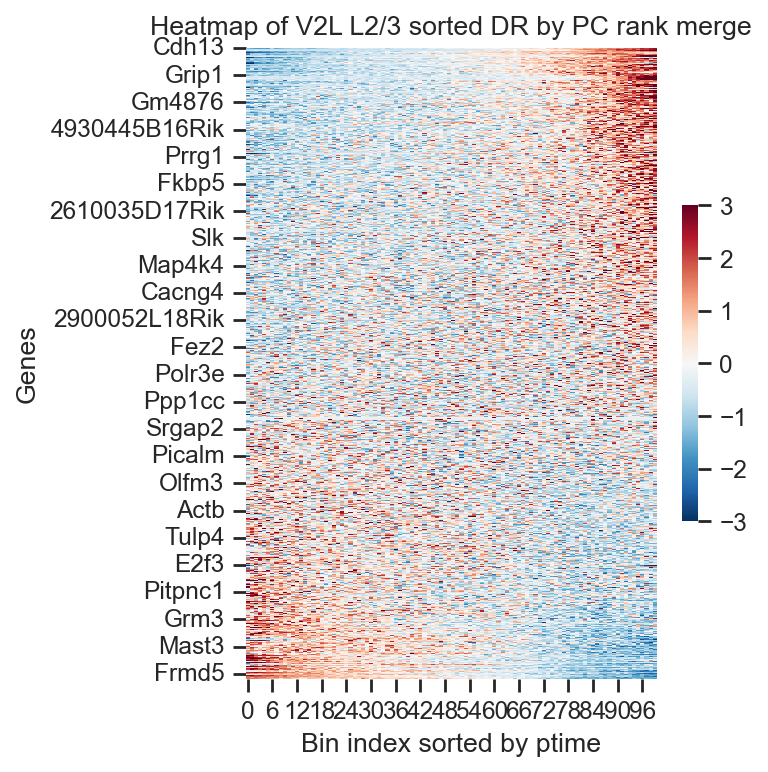

In [22]:
rank_df = pd.DataFrame()
rank_df.index=list(dr_pc_gene_filter['Gene'])
rank_df['PC_rank']= list(dr_pc_gene_filter['Rank'])
rank_dic = rank_df.to_dict()

PC_rank = []
for i in range(bin_means_dr_T.shape[0]):
    if bin_means_dr_T.index[i] in rank_df['PC_rank'].keys():
        PC_rank.append(rank_df['PC_rank'][bin_means_dr_T.index[i]])
    else:
        PC_rank.append('No')
bin_means_dr_T['PC_rank'] = PC_rank

bin_means_dr_T_pc_gene = bin_means_dr_T[bin_means_dr_T['PC_rank'] != 'No']

bin_means_dr_T_pc_gene_sorted = bin_means_dr_T_pc_gene.sort_values(by='PC_rank', ascending=True)

bin_means_dr_T_pc_gene_sorted_positive = bin_means_dr_T_pc_gene_sorted[bin_means_dr_T_pc_gene_sorted['slope'] >= 0]
bin_means_dr_T_pc_gene_sorted_negtive = bin_means_dr_T_pc_gene_sorted[bin_means_dr_T_pc_gene_sorted['slope'] <= 0]
df_dr_reversed = bin_means_dr_T_pc_gene_sorted_negtive.reindex(index=bin_means_dr_T_pc_gene_sorted_negtive.index[::-1])

df_dr_combined = pd.concat([bin_means_dr_T_pc_gene_sorted_positive, df_dr_reversed])
del df_dr_combined['slope']
del df_dr_combined['PC_rank']
# 使用 seaborn 绘制热图
# 按行计算 Z-score
df_dr_combined_zscore = df_dr_combined.apply(zscore, axis=1)
plt.figure(figsize=(5,5))
sns.heatmap(df_dr_combined_zscore, cmap='RdBu_r', fmt='.2f',vmin=-3,vmax=3,cbar_kws={ 'shrink': 0.5})
plt.title('Heatmap of V2L L2/3 sorted DR by PC rank merge')
plt.xlabel('Bin index sorted by ptime')
plt.ylabel('Genes')
plt.tight_layout()
plt.savefig('Heatmap_of_V2L_L23_sorted_DR_by_PC_rank_merge.pdf')

In [23]:
hvg_nr

View of AnnData object with n_obs × n_vars = 4324 × 3275
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'dendrogram_leiden_res_1.50', 'hvg', 'leiden_res_1.50', 'leiden_res_1.50_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [24]:
hvg_dr

View of AnnData object with n_obs × n_vars = 4067 × 3625
    obs: 'n_genes', 'n_counts', 'doublet_score', 'Sample', 'Class', 'Subclass', 'Subtype', 'Ann_subclass_cell', 'Type'
    var: 'gene_ids', 'feature_types', 'n_cells-V2L_1', 'highly_variable-V2L_1', 'means-V2L_1', 'dispersions-V2L_1', 'dispersions_norm-V2L_1', 'n_cells-V2L_2', 'highly_variable-V2L_2', 'means-V2L_2', 'dispersions-V2L_2', 'dispersions_norm-V2L_2', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'Sample_colors', 'Subclass_colors', 'Subtype_colors', 'Type_colors', 'dendrogram_leiden_res_1.50', 'hvg', 'leiden_res_1.50', 'leiden_res_1.50_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'